<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch19_training_deploying_tf_at_scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 19 — Training and Deploying TensorFlow Models at Scale

## 1) Summary
In this chapter, I focus on **what changes when a TensorFlow model must be trained and deployed beyond a notebook**.

What I implement and document in this notebook:
- Build a clean **tf.data** input pipeline (efficient, reproducible).
- Train a model with **distribution strategies** (single-device → mirrored training pattern).
- Use practical training tooling:
  - callbacks (TensorBoard, checkpoints, early stopping),
  - performance knobs (batching, caching, prefetching),
  - optional mixed precision (when GPU supports it).
- Export a model as a **SavedModel** for serving/inference.
- Load the SavedModel back and run inference using the **serving signature**.
- Convert the SavedModel to **TensorFlow Lite** and run inference with a TFLite Interpreter.

The goal is to reproduce the “end-to-end” mindset for scale:
**pipeline → train reliably → export → validate reloaded model → convert for deployment**.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))

TensorFlow: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2) Notes I keep in mind for “scale” work

### 2.1 Training at scale (practical meaning)
Scaling training usually means at least one of:
- bigger datasets (input pipeline matters),
- bigger models (performance + stability),
- more compute devices (multi-GPU / multi-worker),
- longer training runs (logging + checkpointing becomes mandatory).

### 2.2 Deployment at scale (practical meaning)
Scaling deployment usually means:
- stable model serialization (SavedModel),
- consistent preprocessing at inference time,
- reproducible signatures for serving,
- multiple target platforms (server, mobile via TFLite, browser via TFJS).

This notebook demonstrates patterns that work in Colab, while also showing the “production-shaped” steps.

# Part A — Dataset + tf.data Pipeline

## 3) Load dataset (Fashion MNIST)
I use Fashion MNIST because:
- small and fast to run,
- image-like inputs,
- works for demonstrating tf.data, export, and conversion steps.

Pipeline goals:
- normalization
- batching
- caching and prefetching

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Add channel dimension for Conv2D: (28,28) -> (28,28,1)
X_train_full = X_train_full[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Train/valid split
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_train.shape, X_valid.shape, X_test.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 128

def make_ds(X, y, training=False, batch_size=128):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(10_000, seed=42, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.cache()          # helpful when dataset fits in RAM (true here)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True, batch_size=batch_size)
valid_ds = make_ds(X_valid, y_valid, training=False, batch_size=batch_size)
test_ds  = make_ds(X_test, y_test, training=False, batch_size=batch_size)

for xb, yb in train_ds.take(1):
    print(xb.shape, yb.shape, xb.dtype, yb.dtype)

(128, 28, 28, 1) (128,) <dtype: 'float32'> <dtype: 'uint8'>


## 4) A baseline CNN model
I keep the model small, but “production-shaped”:
- Conv → BN → ReLU blocks
- GlobalAveragePooling (fewer params than Flatten)
- Dropout for regularization

This trains fast and exports cleanly.

In [4]:
def build_cnn_model():
    inputs = keras.layers.Input(shape=(28, 28, 1), name="image")
    x = keras.layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(2)(x)

    x = keras.layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.MaxPooling2D(2)(x)

    x = keras.layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(10, activation="softmax", name="proba")(x)
    return keras.Model(inputs, outputs, name="fashion_cnn")

model = build_cnn_model()
model.summary()

Model: "fashion_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ proba (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,634 (369.66 KB)

 Trainable params: 94,186 (367.91 KB)

 Non-trainable params: 448 (1.75 KB)

# Part B — Training Tooling (callbacks + logging)

## 5) Why callbacks matter in longer runs
When training at scale, I usually need:
- TensorBoard logs for learning curves,
- checkpoints so progress is not lost,
- early stopping to avoid wasting compute.

In [5]:
import datetime

log_dir = os.path.join("logs", "ch19", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
ckpt_dir = os.path.join("checkpoints", "ch19")
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "fashion_cnn.keras"),
        save_best_only=True,
        monitor="val_accuracy",
        mode="max"
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=3,
        restore_best_weights=True
    )
]

print("TensorBoard log dir:", log_dir)

TensorBoard log dir: logs/ch19/20260109-003406


### (Colab) TensorBoard
If you want to visualize logs in Colab:
```python
%load_ext tensorboard
%tensorboard --logdir logs
```

# Part C — Distribution Strategy (single/multi-device pattern)

## 6) Why distribution strategies?
`tf.distribute` standardizes how I scale training:
- single CPU/GPU → still works
- multi-GPU (mirrored) → same code structure
- multi-worker → similar code, different cluster config

Here I choose a safe strategy and train with the same `model.fit()` API.

In [6]:
gpus = tf.config.list_physical_devices("GPU")

if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")

print("Strategy:", type(strategy).__name__)
print("Num replicas in sync:", strategy.num_replicas_in_sync)

Strategy: MirroredStrategy
Num replicas in sync: 1


## 7) (Optional) Mixed precision
Mixed precision can speed training on modern GPUs by using float16 where safe.
I enable it only when a GPU is available.

In [7]:
use_mixed_precision = len(gpus) > 0
if use_mixed_precision:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision policy:", mixed_precision.global_policy())
else:
    print("Mixed precision skipped (no GPU detected).")

Mixed precision policy: <DTypePolicy "mixed_float16">


## 8) Compile + Train inside strategy scope
Important: when using a strategy, I create/compile the model inside `strategy.scope()`.

If mixed precision is enabled, I keep the final softmax output in float32 for numeric stability.

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6713 - loss: 0.9782 - val_accuracy: 0.4656 - val_loss: 1.9217
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8401 - loss: 0.4604 - val_accuracy: 0.8280 - val_loss: 0.4546
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8635 - loss: 0.3924 - val_accuracy: 0.8314 - val_loss: 0.4731
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8711 - loss: 0.3617 - val_accuracy: 0.8624 - val_loss: 0.3841
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8781 - loss: 0.3339 - val_accuracy: 0.8670 - val_loss: 0.3618
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8859 - loss: 0.3147 - val_accuracy: 0.8872 - val_loss: 0.3078
Epoch 7/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8898 - loss: 0.3041 - val_accuracy: 0.8624 - val_loss: 0.3648
Epoch 8/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8950 - loss: 0.2887 - val_acc

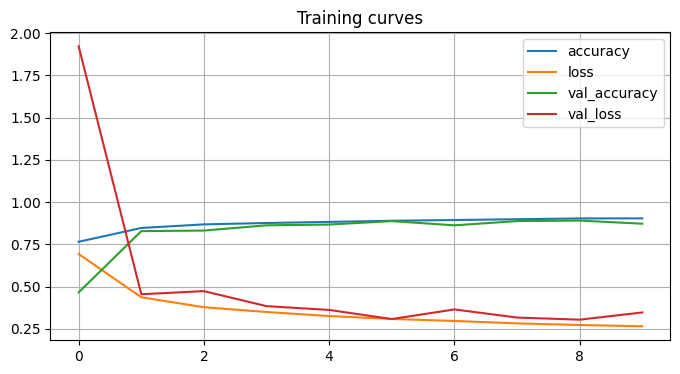

In [8]:
with strategy.scope():
    model_dist = build_cnn_model()

    if use_mixed_precision:
        # keep output layer in float32 under mixed precision
        model_dist.get_layer("proba").dtype_policy = tf.keras.mixed_precision.Policy("float32")

    model_dist.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )

history = model_dist.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

pd.DataFrame(history.history).plot(figsize=(8, 4), grid=True, title="Training curves")
plt.show()

In [9]:
test_loss, test_acc = model_dist.evaluate(test_ds, verbose=0)
test_loss, test_acc

(0.33987709879875183, 0.8809000253677368)

# Part D — Exporting for Deployment (SavedModel)

## 9) Why SavedModel?
SavedModel is TensorFlow’s standard format for deployment:
- preserves model graph and weights
- supports signatures for serving
- integrates with TF Serving and TF Lite conversion

I export to a versioned folder structure often used in TF Serving:
`export_dir/1/`

In [12]:
export_root = os.path.join("exported_models", "fashion_cnn")
export_version = "1"
export_dir = os.path.join(export_root, export_version)
os.makedirs(export_dir, exist_ok=True)

# Save as SavedModel
model_dist.export(export_dir)  # SavedModel format
print("SavedModel exported to:", export_dir)

Saved artifact at 'exported_models/fashion_cnn/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132764061581776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061583888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061584080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061583312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061583696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061582160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061585232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061584272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061584656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061582352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061

## 10) Reload SavedModel + verify inference
After export, I reload the SavedModel and:
- inspect available signatures
- run a small prediction check to confirm it works end-to-end

In [13]:
reloaded = tf.saved_model.load(export_dir)
list(reloaded.signatures.keys())

['serve', 'serving_default']

In [14]:
infer = reloaded.signatures.get("serving_default", None)
print("Has serving_default:", infer is not None)

sample = X_test[:4]
sample_tf = tf.convert_to_tensor(sample, dtype=tf.float32)

if infer is not None:
    out = infer(image=sample_tf)
    print("Output keys:", out.keys())
    first_key = list(out.keys())[0]
    preds = out[first_key].numpy()
else:
    preds = reloaded(sample_tf).numpy()

preds.shape, np.argmax(preds, axis=1), y_test[:4]

Has serving_default: True
Output keys: dict_keys(['output_0'])


((4, 10), array([9, 2, 1, 1]), array([9, 2, 1, 1], dtype=uint8))

## 11) Export with an explicit serving signature
Sometimes I want explicit control over the model’s inference signature.
I define a `tf.function` with an input signature and export it.

In [17]:
export_dir_sig = os.path.join(export_root, "2_with_signature")

# Use ExportArchive for Keras 3 compatibility
from tensorflow.keras.export import ExportArchive

export_archive = ExportArchive()
export_archive.track(model_dist)

@tf.function(input_signature=[tf.TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name="image")])
def serving_default(image):
    proba = model_dist(image, training=False)
    return {"proba": proba}

export_archive.add_endpoint(
    name="serving_default",
    fn=serving_default
)

export_archive.write_out(export_dir_sig)
print("SavedModel with explicit signature:", export_dir_sig)

reloaded_sig = tf.saved_model.load(export_dir_sig)
list(reloaded_sig.signatures.keys())

Saved artifact at 'exported_models/fashion_cnn/2_with_signature'. The following endpoints are available:

* Endpoint 'serving_default'
  image (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='image')
Output Type:
  Dict[['proba', TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)]]
Captures:
  132764061581776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061583888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061584080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061583312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061583696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061582160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061585232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061584272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061584656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132764061582352: TensorSpec(shap

['serving_default']

In [18]:
infer2 = reloaded_sig.signatures["serving_default"]
preds2 = infer2(image=sample_tf)["proba"].numpy()
np.allclose(preds[:2], preds2[:2], atol=1e-5), preds2.shape

(True, (4, 10))

# Part E — TensorFlow Lite Conversion (edge/mobile deployment)

## 12) Why TFLite?
TFLite is optimized for:
- smaller model size
- faster inference on mobile/edge
- compatibility with TFLite runtimes

Here I convert the SavedModel to a `.tflite` file and run inference with a TFLite Interpreter.

In [20]:
tflite_path = os.path.join("tflite", "fashion_cnn.tflite")
os.makedirs(os.path.dirname(tflite_path), exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir_sig)

# Enable TF Select ops to handle operations (like float16 Conv2D) not in standard TFLite
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()

with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model saved to:", tflite_path)
print("TFLite size (KB):", round(os.path.getsize(tflite_path) / 1024, 1))

TFLite model saved to: tflite/fashion_cnn.tflite
TFLite size (KB): 195.2


In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_details, output_details

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


([{'name': 'serving_default_image:0',
   'index': 0,
   'shape': array([ 1, 28, 28,  1], dtype=int32),
   'shape_signature': array([-1, 28, 28,  1], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'StatefulPartitionedCall:0',
   'index': 39,
   'shape': array([ 1, 10], dtype=int32),
   'shape_signature': array([-1, 10], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}])

In [23]:
x_in = sample.astype(np.float32)

expected_dtype = input_details[0]["dtype"]
if expected_dtype != x_in.dtype:
    x_in = x_in.astype(expected_dtype)

# Resize input to handle batch size > 1
input_index = input_details[0]["index"]
interpreter.resize_tensor_input(input_index, x_in.shape)
interpreter.allocate_tensors()

interpreter.set_tensor(input_index, x_in)
interpreter.invoke()

output_index = output_details[0]["index"]
tflite_out = interpreter.get_tensor(output_index)

tflite_out.shape, np.argmax(tflite_out, axis=1), y_test[:4]

((4, 10), array([9, 2, 1, 1]), array([9, 2, 1, 1], dtype=uint8))

## 13) Optional: dynamic range quantization
Quantization can reduce model size and sometimes improve inference speed.
Here is a simple dynamic range quantization recipe.

In [25]:
tflite_q_path = os.path.join("tflite", "fashion_cnn_dynamic_range.tflite")

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir_sig)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable TF Select ops to handle operations (like float16 Conv2D) not in standard TFLite
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_q = converter.convert()

with open(tflite_q_path, "wb") as f:
    f.write(tflite_q)

print("Quantized TFLite saved to:", tflite_q_path)
print("Quantized size (KB):", round(os.path.getsize(tflite_q_path) / 1024, 1))

Quantized TFLite saved to: tflite/fashion_cnn_dynamic_range.tflite
Quantized size (KB): 191.3


# Part F — Multi-worker training patterns (reference)

## 14) MultiWorkerMirroredStrategy (concept)
For true multi-worker training, I typically:
- set `TF_CONFIG` describing the cluster
- use `tf.distribute.MultiWorkerMirroredStrategy()`
- keep the rest of the code similar (build/compile inside scope, `fit`)

I cannot simulate multiple workers inside a single Colab notebook reliably,
so I include a minimal skeleton below to document the pattern.

In [26]:
# Multi-worker skeleton (reference only; do not run in this notebook):

# import json, os
# os.environ["TF_CONFIG"] = json.dumps({
#     "cluster": {"worker": ["host1:port", "host2:port"]},
#     "task": {"type": "worker", "index": 0}
# })
#
# strategy = tf.distribute.MultiWorkerMirroredStrategy()
# with strategy.scope():
#     model = build_cnn_model()
#     model.compile(...)
# model.fit(train_ds, ...)

print("Multi-worker skeleton included (reference).")

Multi-worker skeleton included (reference).


## 15) Takeaways
- **tf.data** pipelines (batch, cache, prefetch) are a first step toward scalable training.
- Distribution strategies keep my code structure consistent as I move from 1 device to multiple devices.
- Training at scale needs reliability tools: logging, checkpoints, early stopping.
- **SavedModel** is the standard export format for serving and conversion.
- **TFLite** conversion is a practical path for edge/mobile deployment; quantization can shrink size further.
- Even if I train in Colab, I can still export and validate artifacts as if I were preparing for deployment.

## 16) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 19.
- TensorFlow docs: `tf.data`, `tf.distribute`, SavedModel, TensorFlow Lite.